In [1]:
import pandas as pd
import warnings
from sodapy import Socrata
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import matplotlib.pyplot as plt


MTA_client = Socrata("data.ny.gov", None)

ds_dictionary = {
    'ridership': 'vxuj-8kew',
    'subway hourly ridership': 'wujg-7c2s',
    'bus hourly ridership': 'kv7t-n8in',
    'major felonies': 'yeek-jhmu',
    'summonses and arrests': '7tfn-twae'
}

In [2]:
def get_dataset(ds_name: str, begin: str=None, before: str=None, MTA_client=None) -> pd.DataFrame:
    """
    retrieves a pandas dataframe from a corresponding MTA data source
    filters for optional start and end times; careful not passing any start or end times - over 100 million rows for hourly data
    assumes the existence of MTA_client
    """
    sample = MTA_client.get(ds_dictionary[ds_name], limit=1)
    time_columns = [v for v in sample[0].keys() if v.lower().endswith(('date', 'timestamp', 'month'))]
    if MTA_client is None: raise Exception('MTA_client not found; required for connection to data repository')
    
    if len(time_columns) == 0:
        warnings.warn(f'No time column found: {sample[0].keys}')
        try:
            res_dict = MTA_client.get_all(ds_dictionary[ds_name])
            return pd.DataFrame.from_records(res_dict).dropna().reset_index(drop=True)
        except Exception as e:
            raise Exception(f"Couldn't get all rows. Too many? {e}")

    if len(time_columns) > 1:
        raise Exception(f'Too many time columns found: {sample.keys}')

    time_column = time_columns[0]
    where_string = f"{time_column} >= '{begin}'" if begin and not before else ''
    where_string = f"{time_column} < '{before}'" if not begin and before else ''
    where_string = f"{time_column} >= '{begin}' AND {time_column} < '{before}'" if begin and before else ''
    res_dict = MTA_client.get_all(ds_dictionary[ds_name], where=where_string, order=f'{time_column} ASC')
    return pd.DataFrame.from_records(res_dict).dropna().reset_index(drop=True)


def rid_irrelevant_criteria(df: pd.DataFrame, kept: dict) -> pd.DataFrame:
    """
    for a given pandas dataframe, drop column values that match a list of kept values
    ie., kept: {'metrics': 'Arrests'} -> all rows w/o 'Arrests' for 'metrics' column are dropped
    """
    keys = set(kept.keys())
    if keys.intersection(set(df.columns)) != keys:
        raise Exception(f'Kept columns not found in dataframe: {keys.intersection(set(df.columns))}')
    for key in keys:
        if set(df[key].unique()).intersection(kept[key]) != kept[key]:
            raise Exception(f'At least one kept value from column {key} DNE: {kept[key]}') 
    
    for key in keys: 
        df = df.where(df[key].isin(kept[key])).dropna().reset_index(drop=True)
    return df


def aggregate_by_timeframe(df: pd.DataFrame, timeframe: str, typ: str) -> pd.DataFrame:
    """
    aggregates a timeframe by timeframe; results are summed or averaged
    """
    if timeframe not in ['hourly', 'daily', 'weekly', 'monthly']:
        raise Exception(f'Invalid timeframe {timeframe}')
    if typ not in ['mean', 'sum']:
        raise Exception(f'Invalid type {typ}')
    
    time_columns = [v for v in df.columns if v.lower().endswith(('date', 'timestamp', 'month'))]
    if len(time_columns) != 1:
        raise Exception(f'Zero or more than one time column(s) found: {df.columns}')

    time_column = time_columns[0]
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(by=time_column)

    for column in df.columns:
        if column != time_column:
            try:
                df[column] = df[column].astype(float)
            except ValueError:
                warnings.warn(f'Column {column} disregarded for having non-numeric values')
            except TypeError:
                warnings.warn(f'Column {column} disregarded for having non-numeric values')

    df = df.set_index(time_column)
    timeframe_dictionary = {'hourly': 'h', 'daily': 'd', 'weekly': 'W', 'monthly': 'ME'}

    if typ == 'mean': return df.resample(timeframe_dictionary[timeframe]).mean(numeric_only=True).reset_index() 
    if typ == 'sum': return df.resample(timeframe_dictionary[timeframe]).sum(numeric_only=True).reset_index() 


In [3]:
df_crimes = get_dataset('summonses and arrests', MTA_client=MTA_client)
df_crimes = rid_irrelevant_criteria(df_crimes,
        {'metric': {
            'Fare Evasion Arrests',
            'Fare Evasion Criminal Summons',
            'Fare Evasion TABS Summons',
            'Fare Evasion Summons'}})

C:\Users\15698\AppData\Local\Temp\ipykernel_2700\658531659.py:69: UserWarning: Column agency disregarded for having non-numeric values
  warnings.warn(f'Column {column} disregarded for having non-numeric values')
C:\Users\15698\AppData\Local\Temp\ipykernel_2700\658531659.py:69: UserWarning: Column police_force disregarded for having non-numeric values
  warnings.warn(f'Column {column} disregarded for having non-numeric values')
C:\Users\15698\AppData\Local\Temp\ipykernel_2700\658531659.py:69: UserWarning: Column metric disregarded for having non-numeric values
  warnings.warn(f'Column {column} disregarded for having non-numeric values')


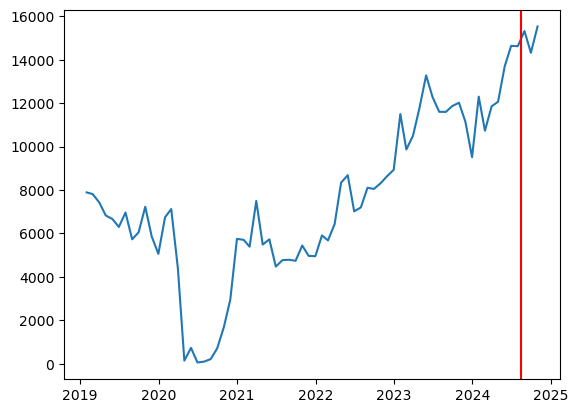

In [4]:
df_crimes_agg = aggregate_by_timeframe(df_crimes, 'monthly', 'sum')
plt.plot(df_crimes_agg.month, df_crimes_agg.total)
plt.axvline(datetime.strptime('2024-08-14', '%Y-%m-%d'), color='red')

In [5]:
import time

start = time.time()

articles = get_articles_by_query('MTA fare evasion', '2022-01-01', '2024-10-01')


print(time.time() - start)

NameError: name 'get_articles_by_query' is not defined

In [ ]:
df = get_articles_df(articles)

 79%|███████████████████████████████████████████████████████████████▏                | 240/304 [01:00<00:17,  3.56it/s]

From below, edited by Yuanwu. 
Analyzing MTA Data

Data for dataset 'ridership' downloaded successfully!
Data cleaned successfully.
Daily ridership aggregated successfully with pre-pandemic estimates.
Event data loaded successfully.
Event data merged with ridership data successfully.


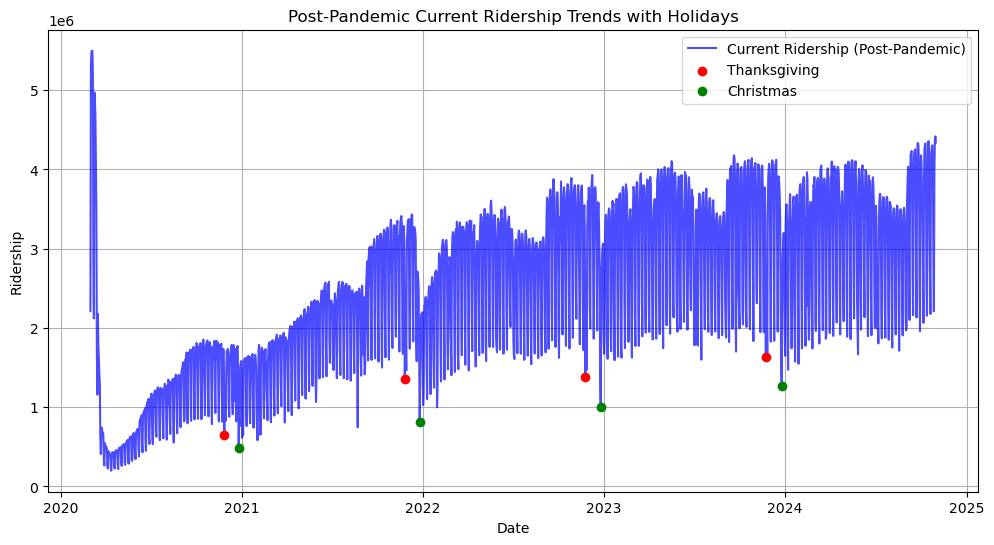

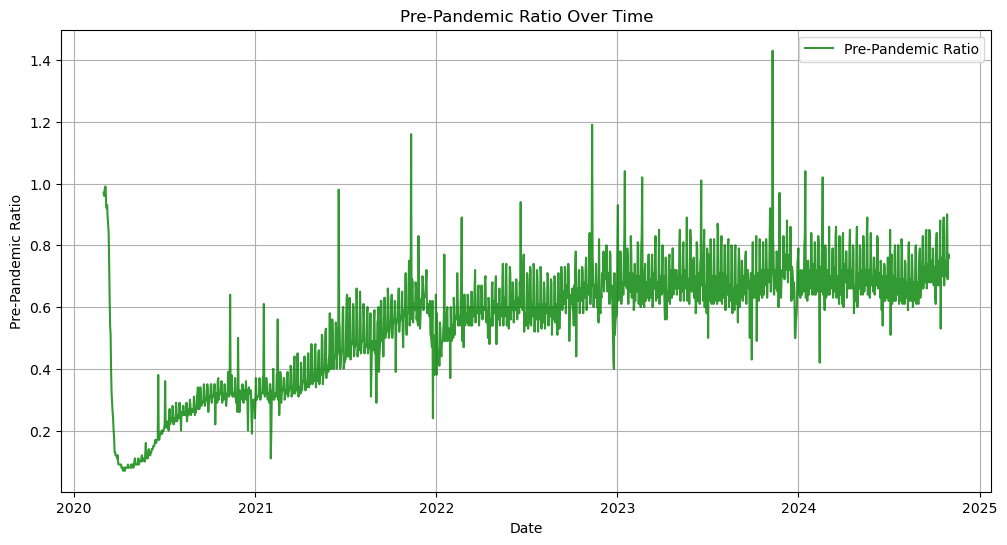

In [1]:
import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt

# Initialize Socrata client
MTA_client = Socrata("data.ny.gov", None, timeout=30)

# Dataset dictionary for easy reference
ds_dictionary = {
    'ridership': 'vxuj-8kew',
    'subway hourly ridership': 'wujg-7c2s',
    'bus hourly ridership': 'kv7t-n8in',
    'major felonies': 'yeek-jhmu',
    'summonses and arrests': '7tfn-twae'
}

class MTATurnstileData:
    def __init__(self, dataset_key='ridership'):
        self.dataset_key = dataset_key
        self.dataset_id = ds_dictionary.get(dataset_key, 'vxuj-8kew')
        self.data = pd.DataFrame()

    def switch_dataset(self, dataset_key):
        if dataset_key in ds_dictionary:
            self.dataset_key = dataset_key
            self.dataset_id = ds_dictionary[dataset_key]
            print(f"Switched to dataset: {dataset_key}")
        else:
            print(f"Dataset key '{dataset_key}' not found. Using current dataset.")

    def download_data(self, start_date=None, end_date=None, limit=5000):
        query = []
        if start_date:
            query.append(f"date >= '{start_date}'")
        if end_date:
            query.append(f"date <= '{end_date}'")
        where_clause = " AND ".join(query) if query else None
        try:
            results = MTA_client.get(self.dataset_id, where=where_clause, limit=limit)
            self.data = pd.DataFrame.from_records(results)
            print(f"Data for dataset '{self.dataset_key}' downloaded successfully!")
        except Exception as e:
            print(f"Error fetching data: {e}")

    def clean_data(self):
        if 'date' in self.data.columns:
            self.data['date'] = pd.to_datetime(self.data['date'])
        self.data.sort_values(by=['date'], inplace=True)
        self.data.drop_duplicates(inplace=True)
        print("Data cleaned successfully.")

    def aggregate_daily_ridership(self):
        date_col = 'date'
        current_ridership_col = 'subways_total_estimated_ridership'
        pre_pandemic_ratio_col = 'subways_of_comparable_pre_pandemic_day'
        if current_ridership_col in self.data.columns and pre_pandemic_ratio_col in self.data.columns:
            self.data[current_ridership_col] = pd.to_numeric(self.data[current_ridership_col], errors='coerce')
            self.data[pre_pandemic_ratio_col] = pd.to_numeric(self.data[pre_pandemic_ratio_col], errors='coerce')
            daily_ridership = self.data.groupby(date_col)[[current_ridership_col, pre_pandemic_ratio_col]].sum().reset_index()
            daily_ridership['pre_pandemic_ridership'] = daily_ridership[current_ridership_col] / daily_ridership[pre_pandemic_ratio_col]
            daily_ridership = daily_ridership.rename(
                columns={
                    current_ridership_col: 'current_ridership',
                    pre_pandemic_ratio_col: 'pre_pandemic_ratio'
                }
            )
            print("Daily ridership aggregated successfully with pre-pandemic estimates.")
            return daily_ridership
        else:
            print(f"Required columns not found in the dataset '{self.dataset_key}'.")
            return pd.DataFrame()

class EventData:
    def __init__(self):
        self.events = pd.DataFrame()

    def load_event_data(self, event_list):
        self.events = pd.DataFrame(event_list)
        self.events['date'] = pd.to_datetime(self.events['date'])
        print("Event data loaded successfully.")

    def merge_with_ridership(self, ridership_data):
        merged_data = pd.merge(ridership_data, self.events, on='date', how='left')
        print("Event data merged with ridership data successfully.")
        return merged_data

def plot_post_pandemic_current_ridership(aggregated_data, event_type, merged_data, post_pandemic_start_date, end_date=None):
    aggregated_data = aggregated_data[aggregated_data['date'] >= pd.to_datetime(post_pandemic_start_date)]
    if end_date:
        aggregated_data = aggregated_data[aggregated_data['date'] <= pd.to_datetime(end_date)]
    plt.figure(figsize=(12, 6))
    plt.plot(aggregated_data['date'], aggregated_data['current_ridership'], label='Current Ridership (Post-Pandemic)', alpha=0.7, color='blue')
    thanksgiving_data = merged_data[merged_data['event_type'] == 'Thanksgiving']
    christmas_data = merged_data[merged_data['event_type'] == 'Christmas']
    plt.scatter(thanksgiving_data['date'], thanksgiving_data['current_ridership'], color='red', label='Thanksgiving', zorder=5)
    plt.scatter(christmas_data['date'], christmas_data['current_ridership'], color='green', label='Christmas', zorder=5)
    plt.xlabel('Date')
    plt.ylabel('Ridership')
    plt.title('Post-Pandemic Current Ridership Trends with Holidays')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pre_pandemic_ratio(aggregated_data, event_type, merged_data, start_date=None, end_date=None):
    if start_date:
        aggregated_data = aggregated_data[aggregated_data['date'] >= pd.to_datetime(start_date)]
    if end_date:
        aggregated_data = aggregated_data[aggregated_data['date'] <= pd.to_datetime(end_date)]
    plt.figure(figsize=(12, 6))
    plt.plot(aggregated_data['date'], aggregated_data['pre_pandemic_ratio'], label='Pre-Pandemic Ratio', color='green', alpha=0.8)
    plt.xlabel('Date')
    plt.ylabel('Pre-Pandemic Ratio')
    plt.title('Pre-Pandemic Ratio Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    mta_data = MTATurnstileData()
    mta_data.download_data(start_date='2020-01-01', limit=1000000)
    mta_data.clean_data()
    daily_ridership = mta_data.aggregate_daily_ridership()
    holiday_events = [
        {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
        {'date': '2020-12-25', 'event_type': 'Christmas'},
        {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
        {'date': '2021-12-25', 'event_type': 'Christmas'},
        {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
        {'date': '2022-12-25', 'event_type': 'Christmas'},
        {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
        {'date': '2023-12-25', 'event_type': 'Christmas'}
    ]
    event_data = EventData()
    event_data.load_event_data(holiday_events)
    merged_data = event_data.merge_with_ridership(daily_ridership)
    plot_post_pandemic_current_ridership(daily_ridership, 'Holiday', merged_data, post_pandemic_start_date='2020-01-01', end_date='2024-10-31')
    plot_pre_pandemic_ratio(daily_ridership, 'Holiday', merged_data, start_date='2020-01-01', end_date='2024-10-31')


In [2]:
class MTABusDataSpecificRoute:
    def __init__(self, route_name):
        self.dataset_key = 'bus hourly ridership'
        self.dataset_id = ds_dictionary.get(self.dataset_key, 'kv7t-n8in')
        self.data = pd.DataFrame()
        self.timestamp_column = None
        self.ridership_column = 'ridership'
        self.route_column = 'bus_route'
        self.route_name = route_name

    def detect_timestamp_column(self):
        possible_columns = ['transit_timestamp', 'timestamp', 'time']
        for col in possible_columns:
            if col in self.data.columns:
                self.timestamp_column = col
                print(f"Detected timestamp column: {self.timestamp_column}")
                return
        raise KeyError("No suitable timestamp column found in the dataset.")

    def download_bus_data(self, start_date=None, end_date=None, limit=5000):
        try:
            # Fetch initial data to detect columns
            initial_results = MTA_client.get(self.dataset_id, limit=1)
            self.data = pd.DataFrame.from_records(initial_results)
            self.detect_timestamp_column()  # Detect the correct timestamp column

            # Build the query after detecting timestamp column
            query = [f"{self.route_column} = '{self.route_name}'"]
            if start_date:
                query.append(f"{self.timestamp_column} >= '{start_date}'")
            if end_date:
                query.append(f"{self.timestamp_column} <= '{end_date}'")
            where_clause = " AND ".join(query) if query else None

            # Fetch filtered data
            results = MTA_client.get(self.dataset_id, where=where_clause, limit=limit)
            self.data = pd.DataFrame.from_records(results)
            print(f"Data for route '{self.route_name}' downloaded successfully!")
        except Exception as e:
            print(f"Error fetching data: {e}")

    def clean_bus_data(self):
        if self.timestamp_column not in self.data.columns:
            raise KeyError(f"Column '{self.timestamp_column}' not found in the dataset.")
        self.data[self.timestamp_column] = pd.to_datetime(self.data[self.timestamp_column], errors='coerce')
        self.data.sort_values(by=[self.timestamp_column], inplace=True)
        self.data.drop_duplicates(inplace=True)
        print(f"Data for route '{self.route_name}' cleaned successfully.")

    def aggregate_bus_ridership(self):
        if self.ridership_column not in self.data.columns:
            raise KeyError(f"Column '{self.ridership_column}' not found in the dataset.")
        self.data[self.ridership_column] = pd.to_numeric(self.data[self.ridership_column], errors='coerce')
        self.data['date_only'] = self.data[self.timestamp_column].dt.date  # Extract only the date
        daily_ridership = self.data.groupby('date_only')[self.ridership_column].sum().reset_index()
        daily_ridership.rename(columns={'date_only': 'date', self.ridership_column: 'daily_ridership'}, inplace=True)
        print(f"Daily ridership for route '{self.route_name}' aggregated successfully.")
        return daily_ridership



In [3]:
if __name__ == "__main__":
    try:
        # Fetch a sample of data
        sample_data = MTA_client.get('kv7t-n8in', limit=1000)
        sample_df = pd.DataFrame.from_records(sample_data)

        # Check for available routes
        if 'bus_route' in sample_df.columns:
            unique_routes = sample_df['bus_route'].unique()
            sorted_routes = sorted(unique_routes)  # Sort the routes alphabetically
            print("Available Routes (Sorted):")
            for route in sorted_routes:
                print(route)
        else:
            print("'bus_route' column not found in the dataset. Check the dataset structure.")
    except Exception as e:
        print(f"Error fetching sample data: {e}")

Available Routes (Sorted):
B1
B100
B103
B12
B13
B14
B15
B16
B17
B2
B20
B24
B25
B26
B3
B31
B35
B36
B38
B39
B4
B41
B42
B43
B44
B44+
B45
B46+
B48
B49
B52
B54
B57
B6
B60
B61
B62
B63
B64
B65
B67
B68
B69
B7
B70
B74
B8
B82
B83
B84
B9
BM1
BM2
BM3
BM5
BX1
BX10
BX11
BX12
BX12+
BX13
BX15
BX16
BX19
BX2
BX20
BX21
BX22
BX23
BX24
BX26
BX28
BX29
BX3
BX30
BX31
BX32
BX34
BX35
BX36
BX38
BX39
BX4
BX40
BX41
BX41+
BX42
BX46
BX4A
BX5
BX6
BX6+
BX7
BX8
BX9
BXM1
BXM10
BXM11
BXM2
BXM3
BXM4
BXM6
BXM7
BXM8
BXM9
M1
M10
M100
M101
M102
M103
M104
M106
M11
M116
M12
M14A+
M14D+
M15
M15+
M2
M20
M21
M23+
M3
M31
M34+
M34A+
M35
M4
M42
M5
M50
M57
M60+
M66
M7
M72
M79+
M8
M86+
M9
M96
M98
Q06
Q07
Q08
Q09
Q1
Q10
Q100
Q102
Q104
Q11
Q110
Q111
Q112
Q113
Q12
Q13
Q15
Q15A
Q16
Q17
Q18
Q19
Q2
Q20A
Q20B
Q21
Q22
Q23
Q24
Q25
Q26
Q27
Q28
Q29
Q3
Q30
Q31
Q32
Q33
Q34
Q35
Q36
Q37
Q38
Q39
Q4
Q40
Q41
Q43
Q44+
Q46
Q47
Q48
Q49
Q5
Q50
Q52+
Q54
Q55
Q56
Q58
Q59
Q60
Q64
Q65
Q66
Q67
Q69
Q70+
Q72
Q76
Q77
Q83
Q84
Q85
Q88
QM1
QM10
QM11
QM12
QM15
QM16
QM17

In [7]:
if __name__ == "__main__":    
    route_name = 'B1'  # Specify the bus route
    start_date = '2020-01-01'

    # Initialize bus data processor
    bus_data_B1 = MTABusDataSpecificRoute(route_name)

    # Download and clean the bus data (only once)
    bus_data_B1.download_bus_data(start_date=start_date, limit=2000000) ### This might take a while. Large dataset
    

Detected timestamp column: transit_timestamp
Data for route 'B1' downloaded successfully!


In [8]:
def compute_event_correlation(daily_ridership, event_data, event_type):
    """
    Computes the correlation between an event (e.g., Thanksgiving or Christmas) and daily ridership.

    Parameters:
        daily_ridership (pd.DataFrame): DataFrame containing 'date' and 'daily_ridership'.
        event_data (pd.DataFrame): DataFrame containing 'date' and 'event_type'.
        event_type (str): The type of event to analyze (e.g., 'Thanksgiving' or 'Christmas').

    Returns:
        float: Correlation coefficient.
    """
    # Ensure 'date' columns are of the same type
    daily_ridership['date'] = pd.to_datetime(daily_ridership['date'], errors='coerce')
    event_data['date'] = pd.to_datetime(event_data['date'], errors='coerce')

    # Merge event data with ridership data
    merged_data = pd.merge(daily_ridership, event_data, on='date', how='left')

    # Add an indicator column for the specific event
    merged_data[f'is_{event_type.lower()}'] = (merged_data['event_type'] == event_type).astype(int)

    # Compute the correlation between the event indicator and ridership
    correlation = merged_data[f'is_{event_type.lower()}'].corr(merged_data['daily_ridership'])
    print(f"Correlation between {event_type} and ridership: {correlation}")
    return correlation


Data for route 'B1' cleaned successfully.
Daily ridership for route 'B1' aggregated successfully.
Correlation between Thanksgiving and ridership: -0.08803792924327236
Correlation between Christmas and ridership: -0.09641262499196389
Thanksgiving Correlation: -0.08803792924327236
Christmas Correlation: -0.09641262499196389


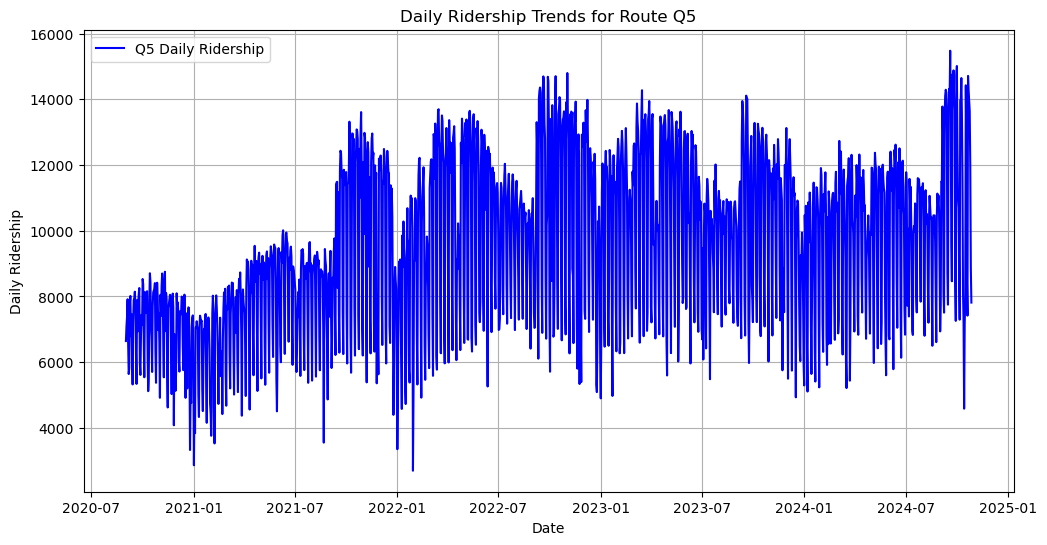

In [23]:
if __name__ == "__main__":  
    try:
        bus_data_B1.clean_bus_data()

        # Aggregate daily ridership
        daily_ridership = bus_data_B1.aggregate_bus_ridership()

        # Prepare event data for correlation
        holiday_events = [
            {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
            {'date': '2020-12-25', 'event_type': 'Christmas'},
            {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
            {'date': '2021-12-25', 'event_type': 'Christmas'},
            {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
            {'date': '2022-12-25', 'event_type': 'Christmas'},
            {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
            {'date': '2023-12-25', 'event_type': 'Christmas'}
        ]
        event_data = pd.DataFrame(holiday_events)
        event_data['date'] = pd.to_datetime(event_data['date'])

        # Compute correlations for Thanksgiving and Christmas
        thanksgiving_correlation = compute_event_correlation(daily_ridership, event_data, 'Thanksgiving')
        christmas_correlation = compute_event_correlation(daily_ridership, event_data, 'Christmas')

        # Print correlation results
        print(f"Thanksgiving Correlation: {thanksgiving_correlation}")
        print(f"Christmas Correlation: {christmas_correlation}")

        # Plot the daily ridership trends
        plt.figure(figsize=(12, 6))
        plt.plot(daily_ridership['date'], daily_ridership['daily_ridership'], label=f'{route_name} Daily Ridership', color='blue')
        plt.xlabel('Date')
        plt.ylabel('Daily Ridership')
        plt.title(f'Daily Ridership Trends for Route {route_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
    except KeyError as e:
        print(f"Error: {e}")

In [10]:
if __name__ == "__main__":    
    route_name = 'Q5'  # Specify the bus route
    start_date = '2020-01-01'

    # Initialize bus data processor
    bus_data_Q5 = MTABusDataSpecificRoute(route_name)

    # Download and clean the bus data (only once)
    bus_data_Q5.download_bus_data(start_date=start_date, limit=2000000) ### This might take a while. Large dataset

Detected timestamp column: transit_timestamp
Data for route 'Q5' downloaded successfully!


Data for route 'Q5' cleaned successfully.
Daily ridership for route 'Q5' aggregated successfully.
Correlation between Thanksgiving and ridership: -0.09739927837145687
Correlation between Christmas and ridership: -0.11989233259903363
Thanksgiving Correlation: -0.09739927837145687
Christmas Correlation: -0.11989233259903363


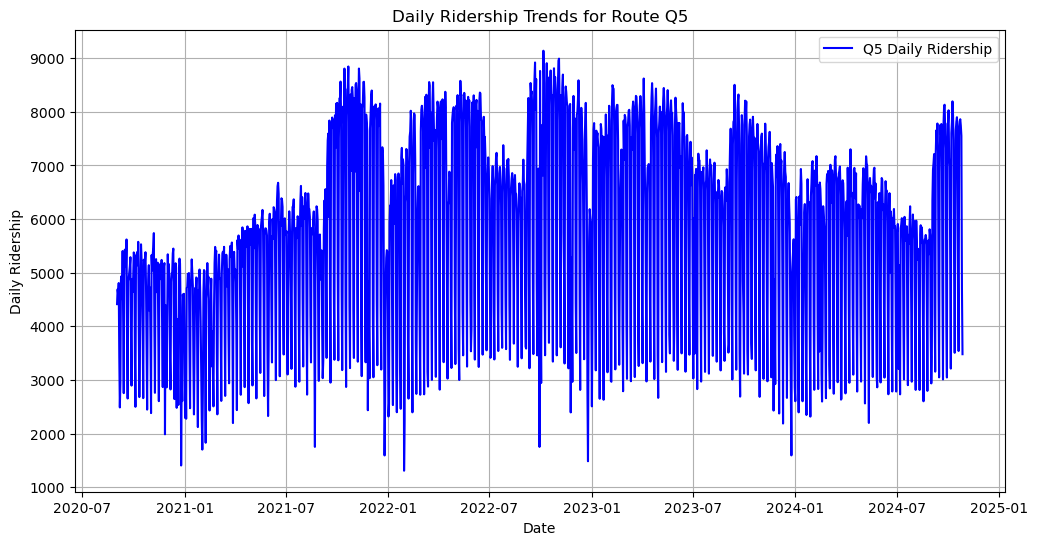

In [24]:
if __name__ == "__main__":  
    try:
        bus_data_Q5.clean_bus_data()

        # Aggregate daily ridership
        daily_ridership = bus_data_Q5.aggregate_bus_ridership()

        # Prepare event data for correlation
        holiday_events = [
            {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
            {'date': '2020-12-25', 'event_type': 'Christmas'},
            {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
            {'date': '2021-12-25', 'event_type': 'Christmas'},
            {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
            {'date': '2022-12-25', 'event_type': 'Christmas'},
            {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
            {'date': '2023-12-25', 'event_type': 'Christmas'}
        ]
        event_data = pd.DataFrame(holiday_events)
        event_data['date'] = pd.to_datetime(event_data['date'])

        # Compute correlations for Thanksgiving and Christmas
        thanksgiving_correlation = compute_event_correlation(daily_ridership, event_data, 'Thanksgiving')
        christmas_correlation = compute_event_correlation(daily_ridership, event_data, 'Christmas')

        # Print correlation results
        print(f"Thanksgiving Correlation: {thanksgiving_correlation}")
        print(f"Christmas Correlation: {christmas_correlation}")

        # Plot the daily ridership trends
        plt.figure(figsize=(12, 6))
        plt.plot(daily_ridership['date'], daily_ridership['daily_ridership'], label=f'{route_name} Daily Ridership', color='blue')
        plt.xlabel('Date')
        plt.ylabel('Daily Ridership')
        plt.title(f'Daily Ridership Trends for Route {route_name}')
        plt.legend()
        plt.grid(True)
        plt.show()
    except KeyError as e:
        print(f"Error: {e}")

The correlation is performed between holidays and non-holidays. The correlations show that both holidays have weak negative correlation, meaning that holidays will decrease ridership but not significantly since correlations are close to 0.

For the following, we want to see how holidays affect hourly ridership for certain bus routes.

In [19]:
def plot_hourly_changes_bar(bus_data, event_data):
    """
    Plot hourly ridership changes for holidays vs non-holidays using a bar plot.

    Parameters:
        bus_data (pd.DataFrame): DataFrame with hourly bus ridership data.
        event_data (pd.DataFrame): DataFrame containing 'date' and 'event_type'.

    Returns:
        None
    """
    # Ensure 'transit_timestamp' is a datetime object
    bus_data['transit_timestamp'] = pd.to_datetime(bus_data['transit_timestamp'])

    # Convert ridership to numeric
    bus_data['ridership'] = pd.to_numeric(bus_data['ridership'], errors='coerce')
    bus_data = bus_data.dropna(subset=['ridership'])

    # Extract date and hour from the timestamp
    bus_data['date'] = bus_data['transit_timestamp'].dt.date
    bus_data['hour'] = bus_data['transit_timestamp'].dt.hour

    # Merge holiday data
    event_data['date'] = pd.to_datetime(event_data['date']).dt.date
    merged_data = pd.merge(bus_data, event_data, on='date', how='left')

    # Mark holidays vs non-holidays
    merged_data['is_holiday'] = merged_data['event_type'].notna()

    # Aggregate hourly data
    hourly_data = merged_data.groupby(['hour', 'is_holiday'])['ridership'].mean().reset_index()

    # Separate data for holidays and non-holidays
    holiday_data = hourly_data[hourly_data['is_holiday']]
    non_holiday_data = hourly_data[~hourly_data['is_holiday']]

    # Fill missing hours with 0
    all_hours = pd.DataFrame({'hour': range(24)})
    holiday_data = all_hours.merge(holiday_data, on='hour', how='left').fillna({'ridership': 0})
    non_holiday_data = all_hours.merge(non_holiday_data, on='hour', how='left').fillna({'ridership': 0})

    # Bar plot settings
    bar_width = 0.4
    indices = np.arange(24)  # Hours 0-23

    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(indices - bar_width / 2, holiday_data['ridership'], width=bar_width, label='Holidays', color='red')
    plt.bar(indices + bar_width / 2, non_holiday_data['ridership'], width=bar_width, label='Non-Holidays', color='blue')

    # Configure the plot
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Ridership')
    plt.title('Hourly Ridership Trends: Holidays vs Non-Holidays')
    plt.xticks(indices, [str(hour) for hour in range(24)])  # Set x-axis ticks to 0-23
    plt.legend()
    plt.grid(axis='y')
    plt.show()


Data for route 'B1' cleaned successfully.


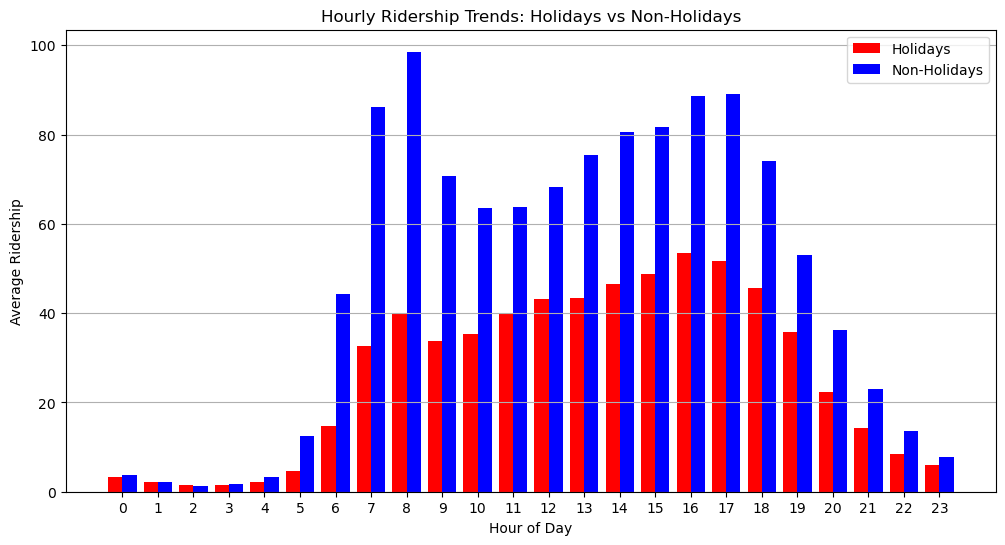

In [26]:
# Clean the data
bus_data_B1.clean_bus_data()

bus_data = bus_data_B1.data  # Access the DataFrame

# Prepare holiday event data
holiday_events = [
    {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
    {'date': '2020-12-25', 'event_type': 'Christmas'},
    {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
    {'date': '2021-12-25', 'event_type': 'Christmas'},
    {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
    {'date': '2022-12-25', 'event_type': 'Christmas'},
    {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
    {'date': '2023-12-25', 'event_type': 'Christmas'}
]
event_data = pd.DataFrame(holiday_events)

# Plot hourly changes using bar chart
plot_hourly_changes_bar(bus_data, event_data)

Data for route 'Q5' cleaned successfully.


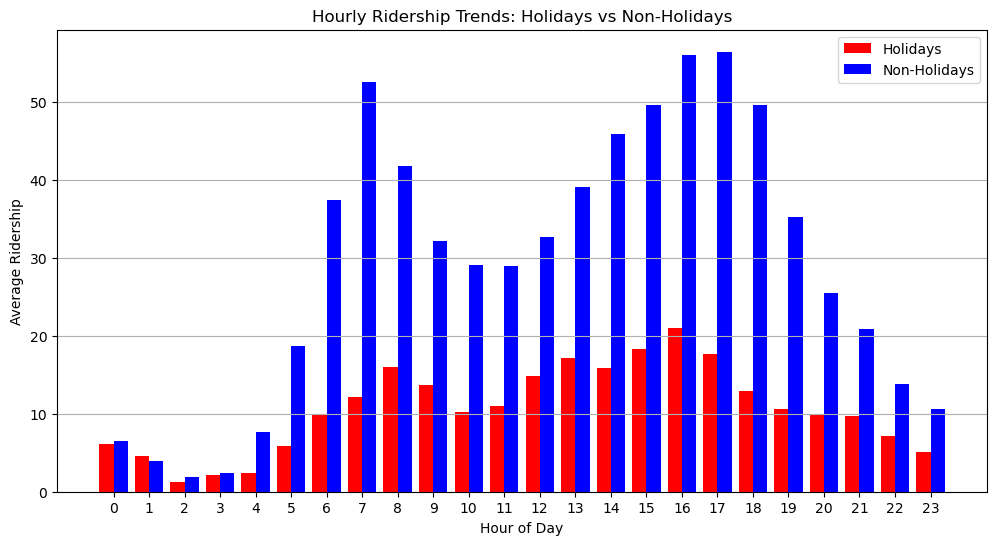

In [30]:
# Clean the data
bus_data_Q5.clean_bus_data()
bus_data = bus_data_Q5.data  # Access the DataFrame

# Prepare holiday event data
holiday_events = [
    {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
    {'date': '2020-12-25', 'event_type': 'Christmas'},
    {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
    {'date': '2021-12-25', 'event_type': 'Christmas'},
    {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
    {'date': '2022-12-25', 'event_type': 'Christmas'},
    {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
    {'date': '2023-12-25', 'event_type': 'Christmas'}
]
event_data = pd.DataFrame(holiday_events)

# Plot hourly changes using bar chart
plot_hourly_changes_bar(bus_data, event_data)

In [ ]:
print(mta_data.data.columns)

Index(['date', 'subways_total_estimated_ridership',
       'subways_of_comparable_pre_pandemic_day',
       'buses_total_estimated_ridersip',
       'buses_of_comparable_pre_pandemic_day',
       'lirr_total_estimated_ridership', 'lirr_of_comparable_pre_pandemic_day',
       'metro_north_total_estimated_ridership',
       'metro_north_of_comparable_pre_pandemic_day',
       'access_a_ride_total_scheduled_trips',
       'access_a_ride_of_comparable_pre_pandemic_day',
       'bridges_and_tunnels_total_traffic',
       'bridges_and_tunnels_of_comparable_pre_pandemic_day',
       'staten_island_railway_total_estimated_ridership',
       'staten_island_railway_of_comparable_pre_pandemic_day'],
      dtype='object')
